In [1]:
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-04-02 22:10:52.313805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 22:10:53.064431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 22:10:58.429639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Model Definition
P3 = 128
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # visual MSM Layers
    self.bigru_visual = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_visual = keras.layers.Dense(128, activation='relu')
    self.msl_2_visual = keras.layers.Dense(P3, activation='relu')

  def __call__(self, visual_input):
    # visual MSM
    bigru_visual_output = self.bigru_visual(visual_input)
    msl_l1_visual = self.msl_1_visual(bigru_visual_output)
    visual_msm_output = self.msl_2_visual(msl_l1_visual)

    return visual_msm_output


# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 7
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, visual_msm_output):
    output_l1 = self.layer_1(visual_msm_output)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# deep dense fusion network with multimodal residual (DFMR)
class SA_Model(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.visual_input = keras.Input(shape=(50, 20))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    visual_msm_output = self.msm(self.visual_input)
    output = self.scm(visual_msm_output)    
    # model definition
    model = keras.Model(inputs=[self.visual_input], outputs=output)
    return model


sa_model = SA_Model()
model = sa_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       427,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,679 (2.05 MB)

 Trainable params: 536,679 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [4]:
# with open('/content/drive/MyDrive/Colab Notebooks/Multimodal Sentiment Analysis/mosi_data.pkl', 'rb') as fp:
#   data = pickle.load(fp)

with open('../../datasets/MOSI/mosi_data.pkl', 'rb') as fp:
  data = pickle.load(fp)

In [5]:
def convertLabels(label):
  result = 0
  if label < -2:
    result = -3
  elif -2 <= label and label < -1:
    result = -2
  elif -1 <= label and label < 0:
    result = -1
  elif 0 <= label and label <= 0:
    result = 0
  elif 0 < label and label <= 1:
    result = 1
  elif 1 < label and label <= 2:
    result = 2
  elif label > 2:
    result = 3
  rep = {
    -3 : [1., 0., 0., 0., 0., 0., 0.],
    -2 : [0., 1., 0., 0., 0., 0., 0.],
    -1 : [0., 0., 1., 0., 0., 0., 0.],
    0 : [0., 0., 0., 1., 0., 0., 0.],
    1 : [0., 0., 0., 0., 1., 0., 0.],
    2 : [0., 0., 0., 0., 0., 1., 0.],
    3 : [0., 0., 0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[result])

def prepare_data(type):
  visual_input = tf.convert_to_tensor(data[type]['vision'])
  labels = [convertLabels(element) for element in data[type]['labels'][:, 0][:, 0]]
  labels = np.array(labels, dtype=np.float32)
  return visual_input, labels

In [6]:
train_visual_input, train_labels = prepare_data('train')
valid_visual_input, valid_labels = prepare_data('valid')

training_dataset = [train_visual_input]
validation_data = ([valid_visual_input], valid_labels)

test_visual_input, test_labels = prepare_data('test')
test_dataset = [test_visual_input]

In [7]:
print(f"Training Input Shape of visual Modality: {train_visual_input.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Input Shape of visual Modality: (1284, 50, 20)
Training Labels Shape: (1284, 7)


In [8]:
print(f"Type of Training Input of visual Modality: {type(train_visual_input)}")
print(f"Type of Training Labels: {type(train_labels)}")

Type of Training Input of visual Modality: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of Training Labels: <class 'numpy.ndarray'>


In [9]:
epochs = 100
history = model.fit(training_dataset, train_labels, validation_data=validation_data, epochs=epochs)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.0000e+00 - loss: 0.2410 - val_accuracy: 0.0000e+00 - val_loss: 0.2298
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.1052 - loss: 0.2209 - val_accuracy: 0.4148 - val_loss: 0.2283
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.4462 - loss: 0.2149 - val_accuracy: 0.4891 - val_loss: 0.2283
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.4924 - loss: 0.2152 - val_accuracy: 0.4910 - val_loss: 0.2283
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.4901 - loss: 0.2174 - val_accuracy: 0.4910 - val_loss: 0.2283
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.4921 - loss: 0.2147 - val_accuracy: 0.4910 - val_loss: 0.2283
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.4918 - loss: 0.2137 - val_accuracy: 0.4910 - val_loss: 0.2283
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.4893 - loss: 0.217

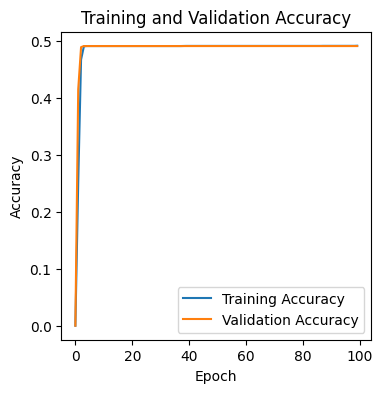

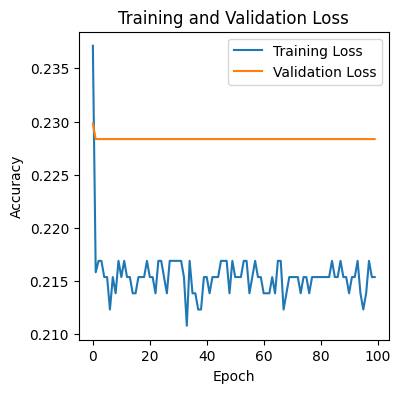

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, test_labels)
print("test loss, test acc:", results)

Evaluate on test data
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4565 - loss: 0.2369
test loss, test acc: [0.23544760048389435, 0.47126203775405884]
